This notebook investigate several strategies to assess how to select hyperparameters for tikhonet.

In [1]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib
import timeit
import numpy as np
import scipy
matplotlib.rcParams['figure.figsize']=[12,8]

In [2]:
matplotlib.rcParams['figure.figsize']=[12,8]

In [3]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('../python/'))
if module_path not in sys.path:
    sys.path.append(module_path)

[[ 0.04505576  0.13511903  0.04505576 -0.00902081]
 [ 0.13511903  0.4052124   0.13511903 -0.02705277]
 [ 0.04505576  0.13511903  0.04505576 -0.00902081]
 [-0.00902081 -0.02705277 -0.00902081  0.0018061 ]]


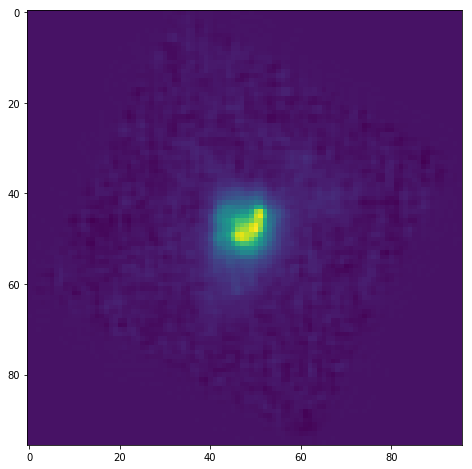

In [4]:
from DeepDeconv.utils.conv_utils import get_conv2d,recenter_psf,perform_shift_in_frequency
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
data_path='/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
gauss_ref=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
#ref=(slice(96,192),slice(96,192)) #for centering
#ref=(slice(96,192),slice(0,96)) #for spiral
ref=(slice(0,96),slice(0,96)) #for test
noise_free_image=fits.getdata(data_path+testset_file,0)[ref]
psf=fits.getdata(data_path+testset_file,1)[ref]
target=fits.getdata(data_path+testset_file,2)[ref]
psf_ctr=recenter_psf(psf,np.array([-0.5,-0.5]))
dirac=np.zeros((96,96))
dirac[47,48]=0.25
dirac[47,47]=0.25
dirac[48,48]=0.25
dirac[48,47]=0.25
dirac_ctr=recenter_psf(dirac,np.array([-0.5,-0.5]))
print(dirac_ctr[47:51,47:51])
dirac_alex= recenter_psf(dirac,np.array([0.5,0.5]))
psf_alex=recenter_psf(psf,np.array([0.5,0.5]))
psf_tar=fits.getdata('/data/DeepDeconv/data/gauss_fwhm0p07/starfield_image-000-0.fits')
plt.imshow(noise_free_image)

In [34]:
dirac_test=np.zeros((96,96))
dirac_test[24,24]=1
print(np.roll(dirac_test,[24,24],axis=[0,1])[0,0])


0.0


# 0) Test centering conventions in fft

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc20ad7af28>,
 <matplotlib.colorbar.Colorbar at 0x7fc20acb7358>)

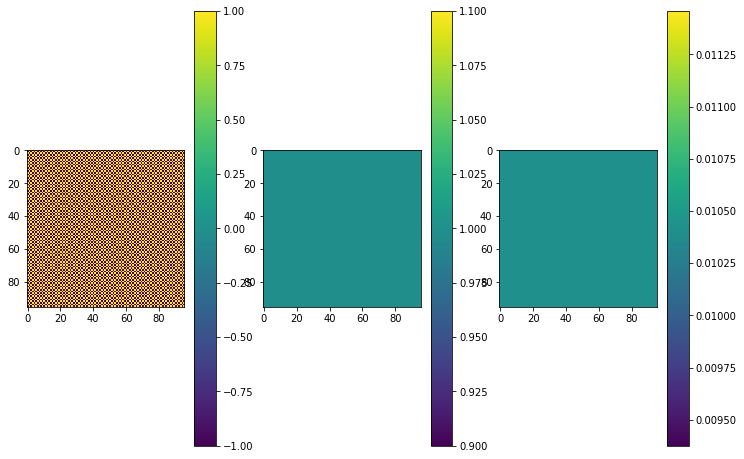

In [130]:
from skimage import restoration
import scipy.fftpack

dirac_psf=np.zeros((96,96))
dir_psf_pos=(0,0)
dirac_psf[dir_psf_pos]=1 #Should be centered, for skimage this is sz//2, and (0,0) for scipy
dirac_irtf=restoration.uft.ir2tf(dirac_psf,dirac_psf.shape, is_real=False)
dirac_tf=restoration.uft.ufft2(dirac_psf)
dirac_fftpack=scipy.fftpack.fft2(dirac_psf)
plt.figure()
plt.subplot(131),plt.imshow(np.real(dirac_irtf)),plt.colorbar()
plt.subplot(132),plt.imshow(np.real(dirac_fftpack)),plt.colorbar()
plt.subplot(133),plt.imshow(np.real(dirac_tf)),plt.colorbar()


## In short: scipy assume center at (0,0), skimage ir2t shifts at (sz[0]//2,sz[1]//2) so that convolution keeps center (sz[0]//2,sz[1]//2) in center (sz[0]//2,sz[1]//2) when using fft

(48, 48)
[47 47]
0.9999999999999999
[47 47]
1.879974300592495e-16


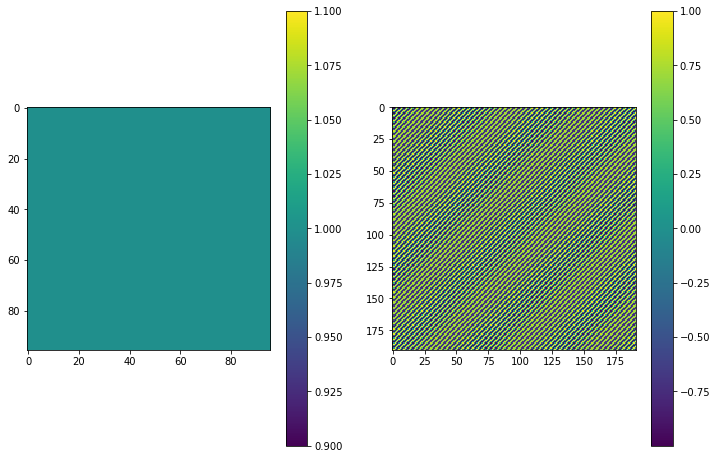

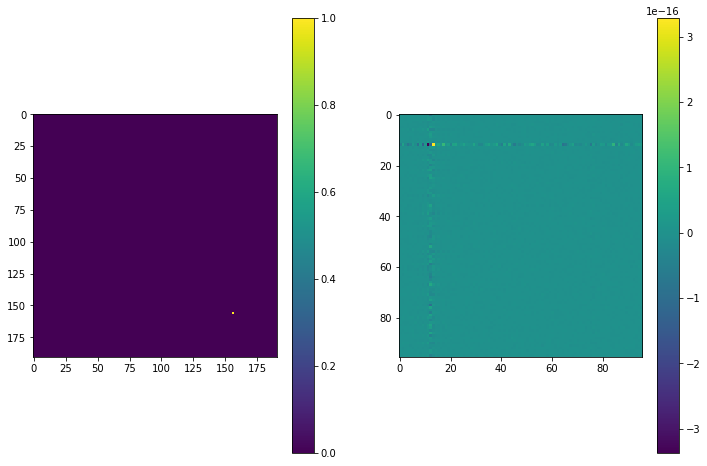

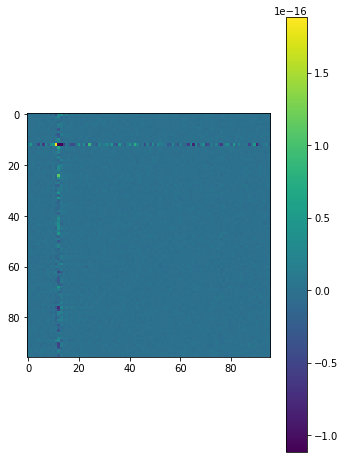

In [27]:
from skimage import restoration

dirac_psf=np.zeros((96,96))
dir_psf_pos=np.array(np.shape(dirac_psf))//2
print(tuple(dir_psf_pos))
dirac_psf[tuple(dir_psf_pos)]=1
dirac_tf=restoration.uft.ir2tf(dirac_psf,dirac_psf.shape, is_real=False)
plt.subplot(121),plt.imshow(np.real(dirac_tf)),plt.colorbar()
dirac_ext_psf=np.zeros((191,191))
dirac_ext_psf[0:dirac_psf.shape[0],0:dirac_psf.shape[1]]=dirac_psf
dirac_ext_tf=restoration.uft.ir2tf(dirac_ext_psf,dirac_ext_psf.shape, is_real=False)
plt.subplot(122),plt.imshow(np.real(dirac_ext_tf)),plt.colorbar()
shift=np.array(np.shape(dirac_ext_psf))//2-np.array(np.shape(dirac_psf))//2
print(shift)

dirac_obs=np.zeros((96,96))
dirac_obs_pos=(12,12)
dirac_obs[dirac_obs_pos]=1
dirac_ext_obs=np.zeros_like(dirac_ext_psf)
dirac_ext_obs[0:dirac_obs.shape[0],0:dirac_obs.shape[1]]=dirac_obs
dirac_ext_conv=restoration.uft.uifft2(restoration.uft.ufft2(dirac_ext_obs)*dirac_ext_tf)
dirac_ext_roll=np.roll(np.real(dirac_ext_conv),shift,(0,1))
plt.figure(),
plt.subplot(121),plt.imshow(np.real(dirac_ext_conv)),plt.colorbar()
plt.subplot(122),plt.imshow(dirac_ext_roll[0:dirac_obs.shape[0],0:dirac_obs.shape[1]]-dirac_obs),plt.colorbar()
print(dirac_ext_roll[dirac_obs_pos])

inv_filter=np.conj(dirac_ext_tf)/(np.abs(dirac_ext_tf)**2)
dirac_ext_inv=np.real(restoration.uft.uifft2(restoration.uft.ufft2(dirac_ext_obs)*inv_filter))
print(shift)
dirac_ext_inv_roll=np.roll(np.real(dirac_ext_inv),-shift,(0,1))
plt.figure(),plt.subplot(121),plt.imshow(dirac_ext_inv_roll[0:dirac_obs.shape[0],0:dirac_obs.shape[1]]-dirac_obs),plt.colorbar()
print(np.max(np.abs(dirac_ext_inv_roll[0:dirac_obs.shape[0],0:dirac_obs.shape[1]]-dirac_obs)))


# 1) Test DIRAC

/home/fsureau/programs/DeepDeconv/python/DeepDeconv/utils/conv_utils.py:92: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ext_psf[cur_slice]= psf


[47 47]


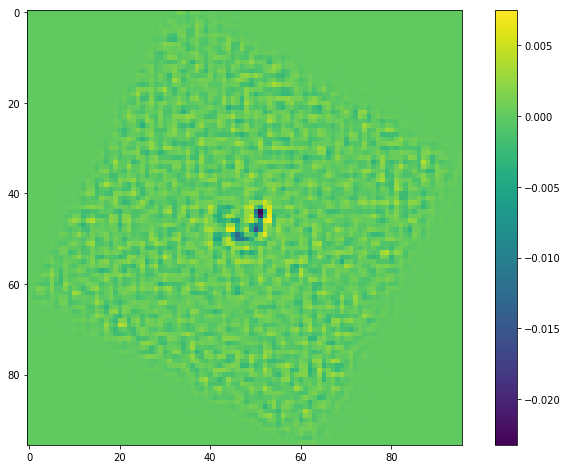

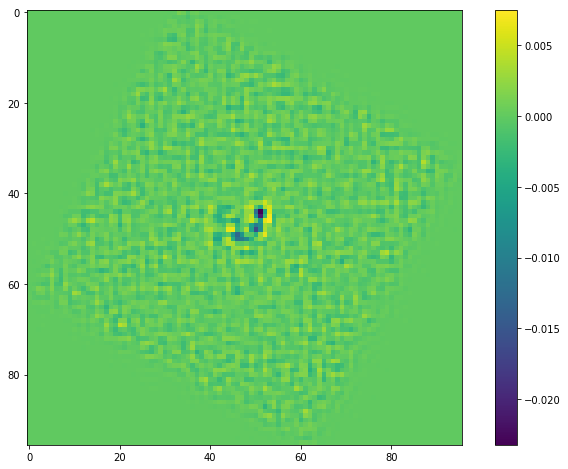

In [7]:
conv1=scipy.signal.fftconvolve(noise_free_image, dirac_ctr,mode="full")
conv2=get_conv2d(noise_free_image, dirac_alex, mode="scipy_fft", transp=False)
conv1_slice=conv1[48:144,48:144]
plt.figure()
plt.imshow(conv1_slice-noise_free_image),plt.colorbar()
plt.figure()
plt.imshow(conv2-noise_free_image),plt.colorbar()
print((np.array(psf.shape)-1)//2)

0.4052123985431758 
 0.4052123985431758 

 [[0.04505576 0.13511903 0.04505576]
 [0.13511903 0.4052124  0.13511903]
 [0.04505576 0.13511903 0.04505576]] 


[[ 0.0018061  -0.00902081 -0.02705277]
 [-0.00902081  0.04505576  0.13511903]
 [-0.02705277  0.13511903  0.4052124 ]] 

 [[ 0.0018061  -0.00902081 -0.02705277]
 [-0.00902081  0.04505576  0.13511903]
 [-0.02705277  0.13511903  0.4052124 ]] 

 [[0.04505576 0.13511903 0.04505576]
 [0.13511903 0.4052124  0.13511903]
 [0.04505576 0.13511903 0.04505576]]


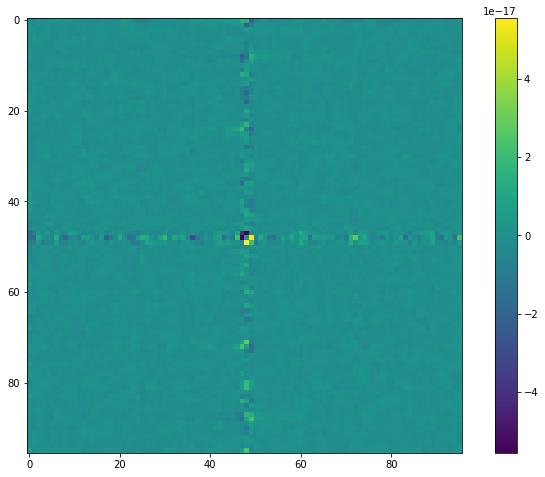

In [28]:
from skimage import restoration
dirac_ctr_T = np.real(restoration.uft.uifft2(np.conj(restoration.uft.ufft2(dirac_ctr))))
plt.imshow(dirac_ctr_T-dirac_ctr),plt.colorbar()
print(dirac_ctr_T[48,48],'\n',dirac_ctr[48,48],'\n\n',np.rot90(dirac_ctr, k=2, axes=(0, 1))[46:49,46:49],'\n\n')
print(dirac_ctr_T[46:49,46:49],'\n\n',dirac_ctr[46:49,46:49],'\n\n',np.rot90(dirac_ctr, k=2, axes=(0, 1))[46:49,46:49])


### In short, the transpose is operating with respect to center at [48,48] and that's why we need to be careful in between conventions with scipy and conventions with skimage

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f9834b05780>)

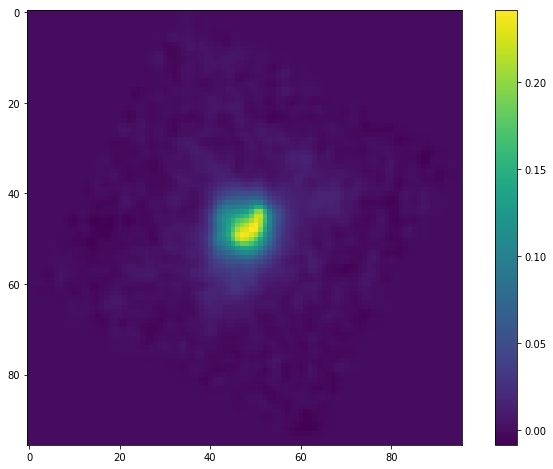

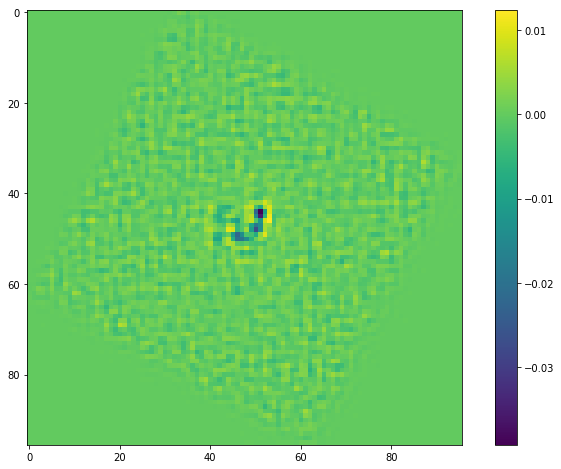

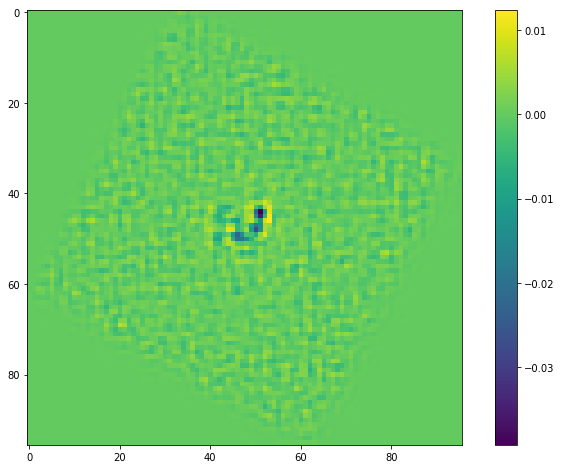

In [9]:
convTconv1=scipy.signal.fftconvolve(conv1_slice, dirac_ctr_T,mode="full")
convTconv1_slice=convTconv1[48:144,48:144]
convTconv2=get_conv2d(conv2, dirac_alex, mode="scipy_fft", transp=True)

plt.figure(),plt.imshow(convTconv2),plt.colorbar()
plt.figure(),plt.imshow(convTconv1_slice-noise_free_image),plt.colorbar()
plt.figure(),plt.imshow(convTconv2-noise_free_image),plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f9834955860>,
 <matplotlib.colorbar.Colorbar at 0x7f9834ade198>)

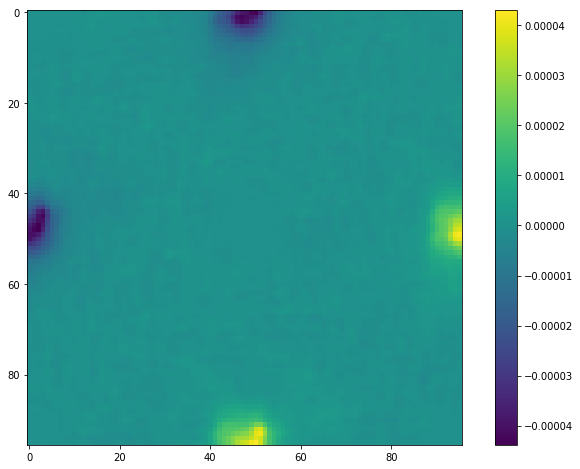

In [13]:
from DeepDeconv.utils.conv_utils import get_conv2d_fftconv
conv1imp=get_conv2d_fftconv(noise_free_image, dirac_ctr, mode="scipy_fft", transp=False)
conv2imp=get_conv2d(noise_free_image, dirac_alex, mode="scipy_fft", transp=False)
plt.figure()
plt.imshow(conv1imp-conv2imp),plt.colorbar()

(<matplotlib.image.AxesImage at 0x7f9834840908>,
 <matplotlib.colorbar.Colorbar at 0x7f9834847e48>)

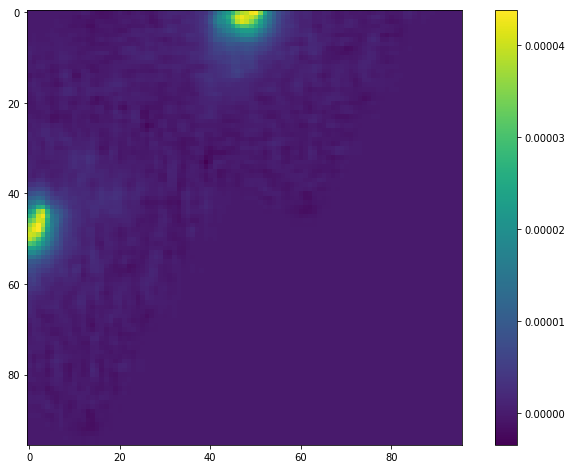

In [12]:
from DeepDeconv.utils.conv_utils import get_conv2d_fftconv
conv1imp=get_conv2d_fftconv(noise_free_image, dirac_ctr, mode="scipy_fft", transp=True)
conv2imp=get_conv2d(noise_free_image, dirac_alex, mode="scipy_fft", transp=True)
plt.figure()
plt.imshow(conv1imp-conv2imp),plt.colorbar()

# 2) Test PSF


[47 47]


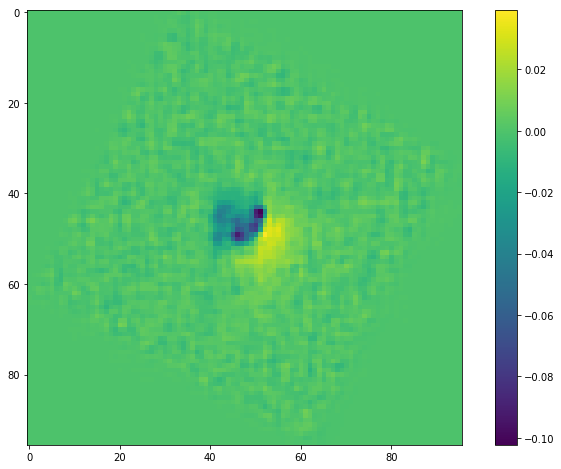

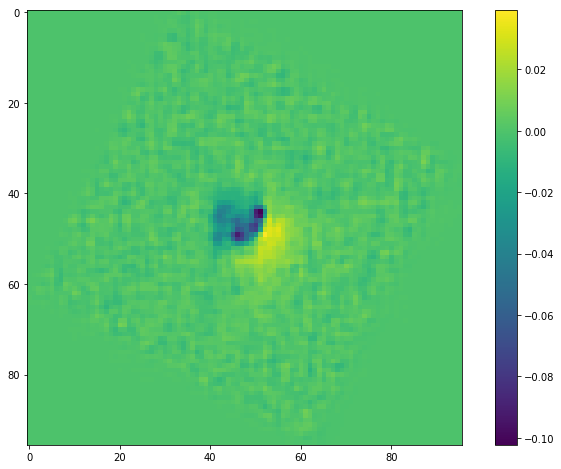

In [96]:
convp1=scipy.signal.fftconvolve(noise_free_image, psf_ctr,mode="full")
convp2=get_conv2d(noise_free_image, psf_alex, mode="scipy_fft", transp=False)
convp1_slice=convp1[48:144,48:144]
plt.figure()
plt.imshow(convp1_slice-noise_free_image),plt.colorbar()
plt.figure()
plt.imshow(convp2-noise_free_image),plt.colorbar()
print((np.array(psf.shape)-1)//2)

ROLL= 1.0
2.5084001169236614e-17 

[[ 1.39708289e-17  3.14441738e-17 -1.17052125e-17  9.75631561e-19]
 [ 1.55558366e-17  1.00000000e+00  7.58461118e-17  2.54960441e-17]
 [-1.21309770e-17  4.16630933e-17  1.30691876e-17 -1.92527620e-20]
 [ 6.35030076e-18  3.23526592e-17 -8.12002750e-18 -4.57775918e-18]]


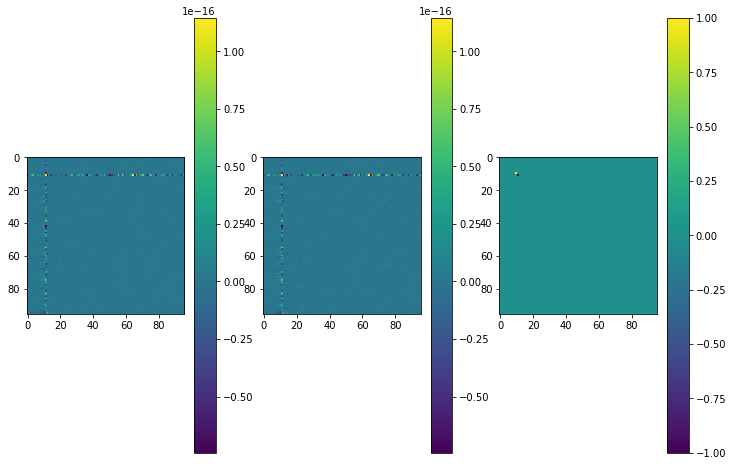

In [180]:
im=noise_free_image
dirac_obs=np.zeros((96,96))
dirac_psf=np.zeros((96,96))
psf_ctr=(np.array(dirac_obs.shape))//2
dirac_obs[12,12]=1
dirac_psf[49,49]=1
print("ROLL=",np.roll(dirac_obs,(-12,-12),axis=(0,1))[0,0])
psf_ctr=(np.array(dirac_psf.shape))//2

ext_size=np.array(dirac_obs.shape)+np.array(im.shape)-1
dirac_obs_ext=np.zeros(ext_size)
dirac_obs_ext[0:96,0:96]=dirac_obs


ext_size=np.array(dirac_obs.shape)+np.array(im.shape)-1
dirac_psf_ext=np.zeros(ext_size)
roll_im=ext_size//2-psf_ctr #This is the shift to center the extended psf if the psf is originally centered 
sl=slice(roll_im[0],roll_im[0]+psf.shape[0]),slice(roll_im[1],roll_im[1]+psf.shape[1])
dirac_psf_ext[sl]=dirac_psf
ref_conv=(np.real(restoration.uft.uifft2(restoration.uft.ufft2(dirac_obs_ext)*np.conj(restoration.uft.ir2tf(dirac_psf_ext,ext_size,is_real=False)))))[0:96,0:96]
print(ref_conv[12,12],'\n')

ext_size=np.array(dirac_obs.shape)+np.array(im.shape)-1
ext_psf_ctr=np.zeros(ext_size)
ext_psf_ctr[0:96,0:96]=dirac_psf
ext_psf_ctr=np.roll(ext_psf_ctr,-psf_ctr,axis=(0,1))
ext_psf_transp=(np.real(restoration.uft.uifft2(np.conj(restoration.uft.ufft2(ext_psf_ctr)))))
psf_transp_roll=np.roll(ext_psf_transp,psf_ctr,axis=(0,1))[0:96,0:96]
conv_roll=scipy.signal.fftconvolve(dirac_obs, psf_transp_roll,mode="full")[psf_ctr[0]:psf_ctr[0]+dirac_obs.shape[0],psf_ctr[1]:psf_ctr[1]+dirac_obs.shape[1]] 


ext_size=np.array(dirac_obs.shape)+np.array(im.shape)-1
ext_psf_ctr=np.zeros(ext_size)
sl=slice(roll_im[0],roll_im[0]+psf.shape[0]),slice(roll_im[1],roll_im[1]+psf.shape[1])
ext_psf_ctr[sl]=dirac_psf
ext_psf_transp2=(np.real(restoration.uft.uifft2(np.conj(restoration.uft.ir2tf(ext_psf_ctr,ext_size,is_real=False)))))#This is centered at 0
psf_transp_roll2=np.roll(ext_psf_transp,psf_ctr,axis=(0,1))[0:96,0:96]
conv_roll2=scipy.signal.fftconvolve(dirac_obs, psf_transp_roll2,mode="full")[psf_ctr[0]:psf_ctr[0]+dirac_obs.shape[0],psf_ctr[1]:psf_ctr[1]+dirac_obs.shape[1]] 

ext_size=np.array(dirac_obs.shape)+np.array(im.shape)-1
dirac_psf_ext=np.zeros(ext_size)
sl=(slice(psf_ctr[0],psf_ctr[0]+dirac_psf.shape[0]),slice(psf_ctr[1],psf_ctr[1]+dirac_psf.shape[1]))
dirac_psf_ext[sl]=dirac_psf
ext_psf = (np.real(restoration.uft.uifft2(np.conj(restoration.uft.ufft2(dirac_psf_ext)))))[sl]
conv_or=scipy.signal.fftconvolve(dirac_obs, ext_psf,mode="full")[psf_ctr[0]:psf_ctr[0]+dirac_obs.shape[0],psf_ctr[1]:psf_ctr[1]+dirac_obs.shape[1]] 


plt.figure()
plt.subplot(131),plt.imshow(conv_roll-ref_conv),plt.colorbar()
plt.subplot(132),plt.imshow(conv_roll2-ref_conv),plt.colorbar()
plt.subplot(133),plt.imshow(conv_or-ref_conv),plt.colorbar()
       #ext_psf_ctr=np.zeros(np.array(psf.shape)*2)
        #sl=(slice(psf_ctr[0],psf_ctr[0]+psf.shape[0]),slice(psf_ctr[1],psf_ctr[1]+psf.shape[1]))
        #ext_psf_ctr[sl]=psf
        #ext_psf = (np.real(restoration.uft.uifft2(np.conj(restoration.uft.ufft2(ext_psf_ctr)))))[sl]
        
print(conv_roll[10:14,10:14])

(<Figure size 864x576 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f784604a7b8>)

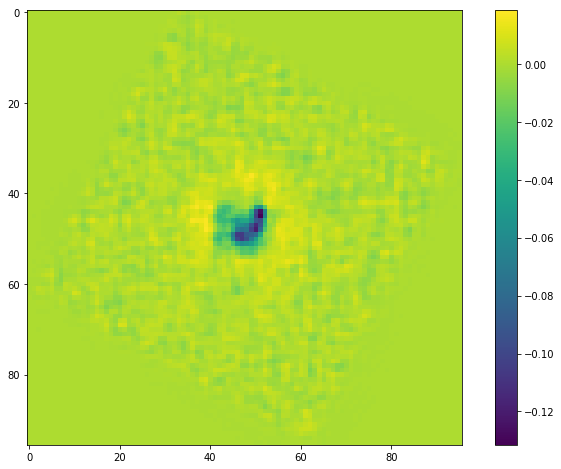

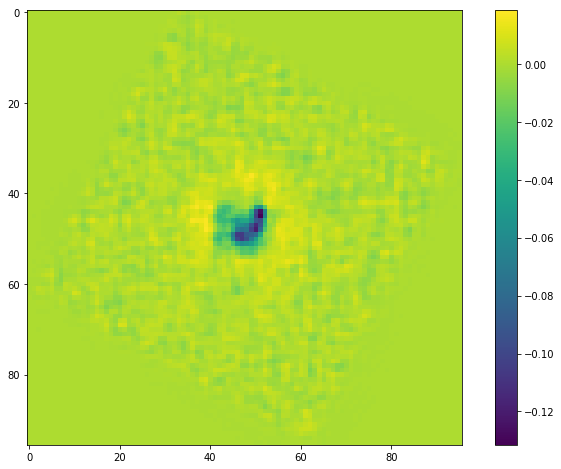

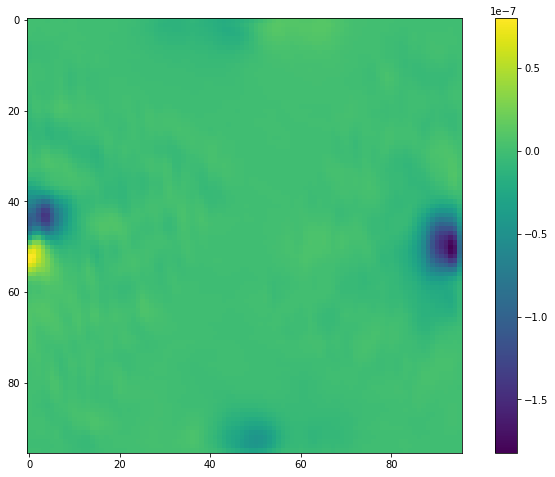

In [116]:
ext_psf_ctr=np.zeros(np.array(psf.shape)*2)
ctr_psf=(np.array(psf.shape)+1)//2
sl=(slice(ctr_psf[0],ctr_psf[0]+psf.shape[0]),slice(ctr_psf[1],ctr_psf[1]+psf.shape[1]))
ext_psf_ctr[sl]=psf_ctr
psf_ctr_T = (np.real(restoration.uft.uifft2(np.conj(restoration.uft.ufft2(ext_psf_ctr)))))[sl]
convTconvp1=scipy.signal.fftconvolve(convp1_slice, psf_ctr_T,mode="full")
convTconvp1_slice=convTconvp1[48:144,48:144]
convTconvp2=get_conv2d(convp2, psf_alex, mode="scipy_fft", transp=True)

plt.figure(),plt.imshow(convTconvp1_slice-noise_free_image),plt.colorbar()
plt.figure(),plt.imshow(convTconvp2-noise_free_image),plt.colorbar()
plt.figure(),plt.imshow(convTconvp2-convTconvp1_slice),plt.colorbar()

In [112]:
print(sl)

slice(array([48, 48]), array([144, 144]), None)


In [110]:
psf

slice(array([[ 5.84312779e-11, -2.77423028e-10,  1.49538657e-10, ...,
        -1.78387944e-10,  2.11730015e-10, -1.75158811e-10],
       [-2.15432003e-10,  2.70795786e-11, -2.48707590e-10, ...,
         2.25041643e-10, -3.21734544e-11,  3.09001332e-10],
       [ 1.67278964e-10, -2.82643300e-10,  2.38685152e-10, ...,
        -8.42212810e-11,  2.63415461e-10, -9.37863591e-12],
       ...,
       [-2.13114781e-10,  2.44340355e-10, -3.33759436e-11, ...,
         3.21423189e-10, -2.67258930e-11,  1.72947990e-10],
       [ 1.85752270e-10, -2.51983072e-11,  3.05902551e-10, ...,
        -8.20457321e-11,  3.02878140e-10, -1.43408878e-10],
       [-2.54485223e-10,  2.24352271e-10, -7.92321814e-11, ...,
         1.15098101e-10, -1.47544518e-10,  9.83288020e-11]]), array([[96., 96., 96., ..., 96., 96., 96.],
       [96., 96., 96., ..., 96., 96., 96.],
       [96., 96., 96., ..., 96., 96., 96.],
       ...,
       [96., 96., 96., ..., 96., 96., 96.],
       [96., 96., 96., ..., 96., 96., 96.],
    

In [296]:
def manual_deconv_l2(noisy_im,trans_func,trans_reg,hyp_param):
    hfstar=np.conj(trans_func)
    h2=np.abs(trans_func)**2
    d2=np.abs(trans_reg)**2
    filter_f=hfstar/(h2+hyp_param*d2)#/SNR_list[0]
    yf=restoration.uft.ufft2(noisy_im)
    sol=np.real(restoration.uft.uifft2(filter_f*yf))
    return sol